<a href="https://colab.research.google.com/github/wmg0034/Kaggle/blob/main/playground_series_s5e4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib as mpl

from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [44]:
def get_data():
    DIR = '/content/drive/MyDrive/Colab/Kaggle/playground_series_s5e4/'


    train   = pd.read_csv(DIR + 'data/train.csv')
    test    = pd.read_csv(DIR + 'data/test.csv')
    sample  = pd.read_csv(DIR + 'data/sample_submission.csv')

    return train.drop(columns=['id']), test.drop(columns=['id']), sample

train,test,sample = get_data()

In [54]:
COLUMNS     = list( train.columns )
FEATURES    = [col for col in COLUMNS if col != 'Listening_Time_minutes']
LABELS      = ['Listening_Time_minutes']
CATS        = list( train.select_dtypes(exclude=np.number).columns )
QUANTS      = list( train.select_dtypes(include=np.number).columns )

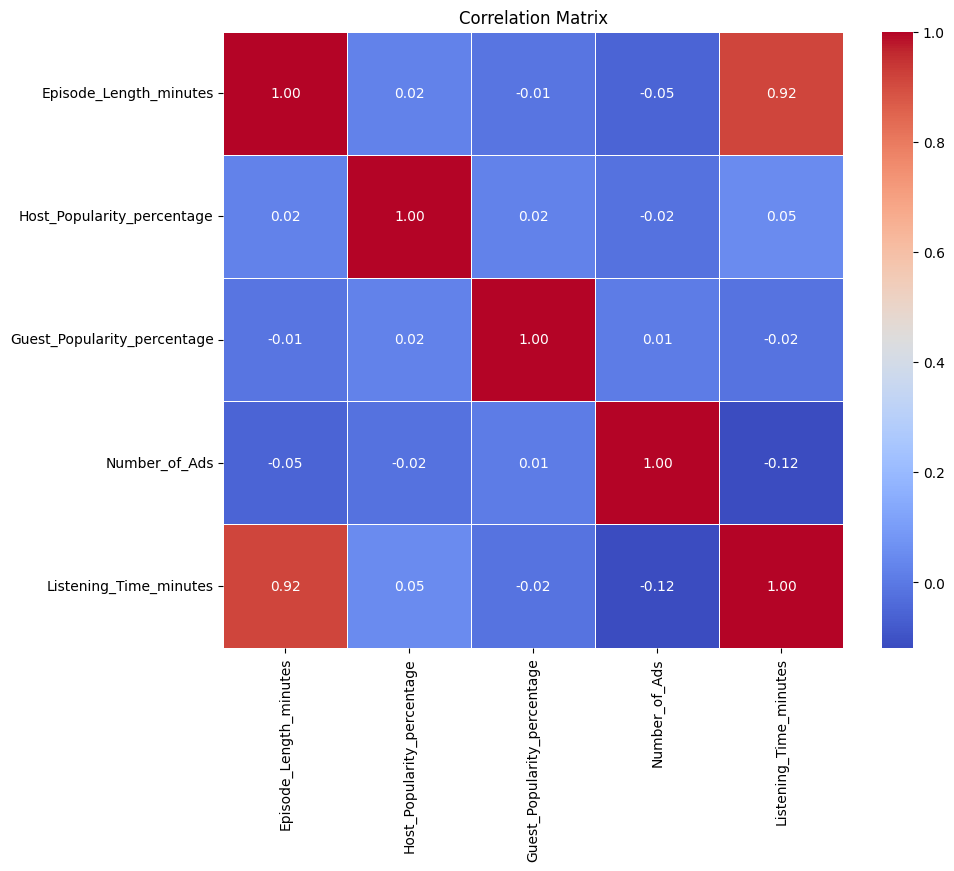

In [20]:
corr = train[QUANTS].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [22]:
na_counts = train.isna().sum()
na_counts

,0
Podcast_Name,0
Episode_Title,0
Episode_Length_minutes,87093
Genre,0
Host_Popularity_percentage,0
Publication_Day,0
Publication_Time,0
Guest_Popularity_percentage,146030
Number_of_Ads,1
Episode_Sentiment,0


<Axes: xlabel='Episode_Length_minutes', ylabel='Listening_Time_minutes'>

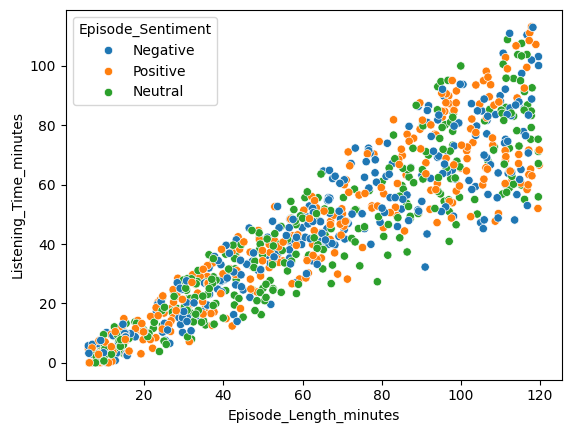

In [28]:
df = train.sample(1000)

sns.scatterplot(
    x       = df['Episode_Length_minutes'],
    y       = df['Listening_Time_minutes'],
    hue     = df['Episode_Sentiment']
    )

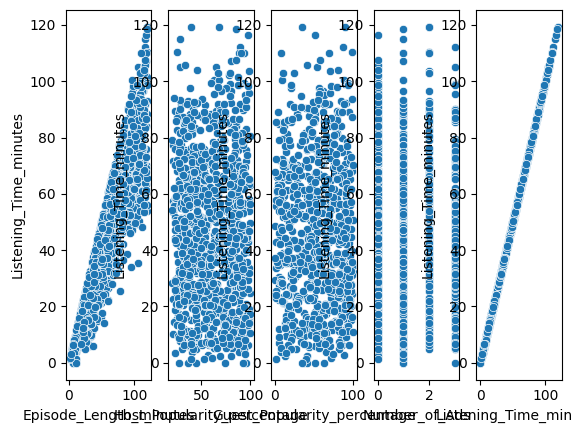

In [63]:
df = train.sample(1000)

fig, ax =plt.subplots(1,len(QUANTS))
fig.figsize=(20,20)



for i, q in enumerate(QUANTS):
    sns.scatterplot(
    x       = df[q],
    y       = df['Listening_Time_minutes'],
    ax      = ax[i]
    )

fig.show()

In [45]:
train['Episode_Length_minutes'].fillna(train['Listening_Time_minutes'], inplace=True)

reg = LinearRegression().fit(
    train['Episode_Length_minutes'].to_numpy().reshape(-1, 1),
    train['Listening_Time_minutes'].to_numpy().reshape(-1, 1)
    )

<ipython-input-45-64a6511644df>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Episode_Length_minutes'].fillna(train['Listening_Time_minutes'], inplace=True)


In [64]:
### maybe need to throw together train and test for group by

group_by_columns = [col for col in CATS if col != 'Episode_Title']
train.groupby(group_by_columns)['Listening_Time_minutes'].agg('mean')

Podcast_Name     Genre       Publication_Day  Publication_Time  Episode_Sentiment
Athlete's Arena  Business    Friday           Afternoon         Positive             63.42770
                             Saturday         Evening           Negative             18.09858
                                              Night             Positive             60.89547
                             Wednesday        Morning           Neutral              58.89526
                 Comedy      Friday           Afternoon         Positive             84.25576
                                                                                       ...   
World Watch      True Crime  Saturday         Afternoon         Negative             56.91282
                                              Evening           Negative             41.26629
                                                                Neutral              28.22616
                                              Night             Negative             52.19056
                             Thursday         Evening           Neutral              56.94636
Name: Listening_Time_minutes, Length: 5370, dtype: float64

In [48]:
test['Episode_Length_minutes'].fillna(, inplace=True)
preds = reg.predict(test['Episode_Length_minutes'].to_numpy().reshape(-1, 1))

KeyError: 'Listening_Time_minutes'

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values